EXERCICE - RECONNAISSANCE CHIEN/CHAT DEPUIS UN DATASET

I. NORMALISAION DES DONNEES

In [155]:
import numpy as np

from utilities import *

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from tqdm import tqdm

Récupération des données de train et de test via la fonction load_data() qui récupère des données depuis les fichiers .hdf5 :

In [156]:
X_train, y_train, X_test, y_test = load_data()

In [157]:
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts = 1))

(1000, 64, 64)
(1000, 1)
(array([0., 1.]), array([500, 500], dtype=int64))


In [158]:
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_test, return_counts = 1))

(200, 64, 64)
(200, 1)
(array([0., 1.]), array([100, 100], dtype=int64))


Affichage des 10 premières photos :

E:\Anaconda\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


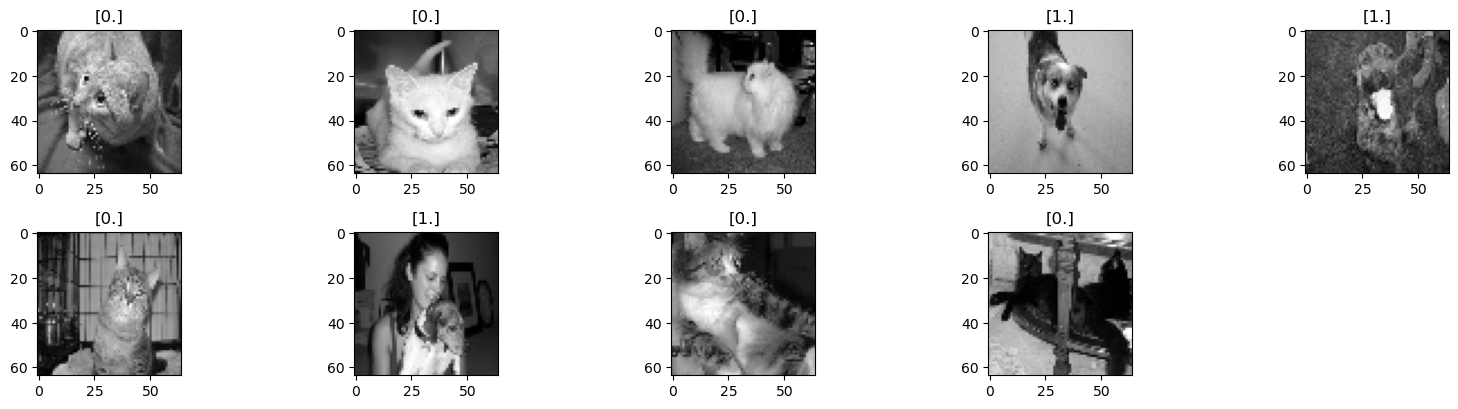

In [159]:
plt.figure(figsize=(16, 8))
for i in range(1, 10):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

On va reshape les données pour prendre les 64 lignes de 64 pixels en 1 ligne de 64 * 64 pixels. On aura donc une dimension de (1000, 64 * 64) et (200, 64 * 64). On peut aussi le traduire par (X_train_shape[0], - 1) et (X_test_shape[0], - 1) là où "- 1" signifie complétion automatique ! [Normalisation Min/Max]

In [160]:
X_train_reshape = X_train.reshape(X_train.shape[0] , -1) / X_train.max()
X_train_reshape.shape

(1000, 4096)

In [161]:
X_test_reshape = X_test.reshape(X_test.shape[0] , -1) / X_train.max()
X_test_reshape.shape

(200, 4096)

II. FONCTIONS

In [162]:
def initialisation(X):
    W = np.random.randn(X.shape[1], 1)
    b = np.random.randn(1)
    return W, b

In [163]:
def modele(W, X, b):
    Z = np.dot(X, W) + b
    A = 1 / (1 + np.exp(-Z))
    return A

Lorsque la probabilité A tend vers 0, étant donné que le logarithme n'est pas défini en 0, il faudra donc ajouter quelque chose dans ces logarithmes comme un "espilon" afin d'éviter une erreur :

In [164]:
def log_loss(A, y):
    epsilon = 1e-15
    L = - 1 / len(y) * np.sum(y * np.log(A + epsilon) + (1 - y) * np.log(1 - A + epsilon))
    return L

In [165]:
def gradients(A, X, y):
    dW = 1 / len(y) * np.dot(X.T, (A - y))
    db = 1 / len(y) * np.sum(A - y)
    return dW, db

In [166]:
def update(W, b, dW, db, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return W, b

In [167]:
def predict(W, X, b):
    A = modele(W, X, b)
    return A >= 0.5

Afin d'afficher une barre de chargement

In [168]:
def artificial_neurone(X_train, X_test, y_train, y_test, learning_rate = 0.1, iteration = 100):
    W, b = initialisation(X_train)

    train_loss = []
    test_loss = []

    train_acc = []
    test_acc = []

    for i in tqdm(range(iteration), desc = 'Calcul du dataset'):
        A = modele(W, X_train, b)

        # Afin d'optimiser le code, on ajoutera dans les listes seulement 1/10 des loss et accuracy :
        # if i % 10 == 0:
        train_loss.append(log_loss(A, y_train))
        y_pred_train = predict(W, X_train, b)
        train_acc.append(accuracy_score(y_train, y_pred_train))

        A_test = modele(W, X_test, b)
        test_loss.append(log_loss(A_test, y_test))
        y_pred_test = predict(W, X_test, b)
        test_acc.append(accuracy_score(y_test, y_pred_test))

        dW, db = gradients(A, X_train, y_train)
        W, b = update(W, b, dW, db, learning_rate)

    # Premier graphique sur la "LOSS" avec la loss du training et test set
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Courbe de perte (Loss)')

    # Deuxième graphique avec l' "ACCURACY" du training et test set
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.plot(test_acc, label='test acc')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Courbe d\'exactitude (Accuracy)')
    plt.show()

    return (W, b)

III. APPLICATION CAT/DOG

Calcul du dataset: 100%|██████████| 135/135 [00:01<00:00, 107.20it/s]


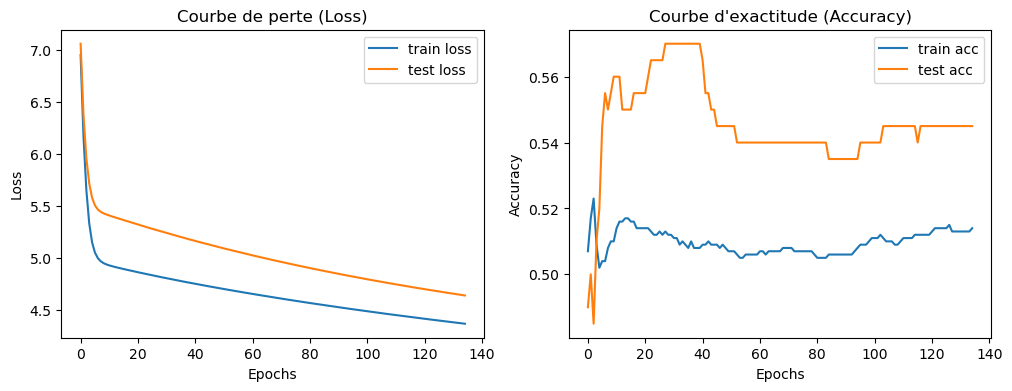

In [169]:
W, b = artificial_neurone(X_train_reshape, X_test_reshape, y_train, y_test, 0.01, 135)

On détecte ici un overfitting si :

1 - On observe que la courbe de train_loss diminue, mais celle du test_loss stagne, voire augmente.
2 - On observe que la courbe du train_acc augmente, alors que celle du test_acc stagne, voire régresse.

Ici, le modèle repose trop sur le training_set aux dépens du testing_set.

Afin de réduire l'overfitting, le premier réflexe serait de fournir plus de données à traiter. De plus, on constate un phénomène qu'on appelle le "fleau de la dimension" lorsqu'un décalage trop important existe entre le nombre de données et le nombre de pixels (en l'occurrence 1000 et 4096). Il est possible d'utiliser des techniques de régularisation pour la pénalité L1 ou L2 [pas encore abordées].

Le souci majeur reste que ce neurone forme un modèle linéaire. Le dataset étant trop complexe, il est impossible de se satisfaire d'un modèle linéaire. Il faut combiner plusieurs neurones afin de construire un réseau assez complexe pour répondre à ce genre de problèmes.

IV. EXPERIENCE SUR LA NORMALISATION

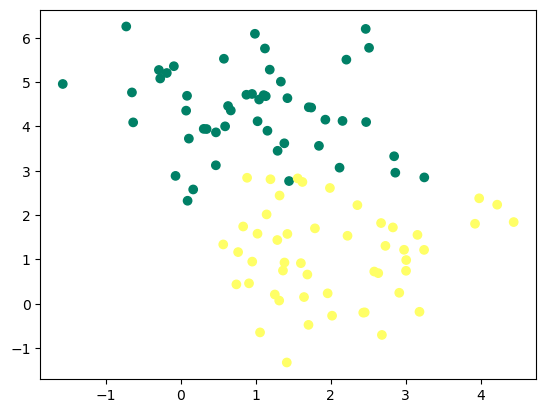

In [170]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples = 100, centers = 2, n_features = 2, random_state = 0)
y = y.reshape((y.shape[0]), 1)

plt.scatter(X[:,0], X[:, 1], c=y, cmap='summer')
plt.show()

In [171]:
lim, h = 10, 100

W1 = np.linspace(-lim, lim, h)
W2 = np.linspace(-lim, lim, h)

W11, W22 = np.meshgrid(W1, W2)

W_final = np.c_[W11.ravel(), W22.ravel()].T
W_final.shape

(2, 10000)

In [172]:
b = 0
epsilon = 1e-15

Z = X.dot(W_final) + b
A = 1 / (1 + np.exp(-Z))

L = - 1 / len(y) * np.sum(y * np.log(A + epsilon) + (1 - y) * np.log(1 - A + epsilon), axis = 0).reshape(W11.shape)

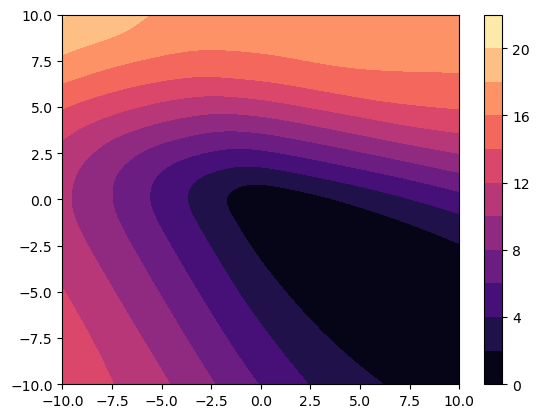

In [173]:
plt.contourf(W11, W22, L, 10, cmap='magma')
plt.colorbar()

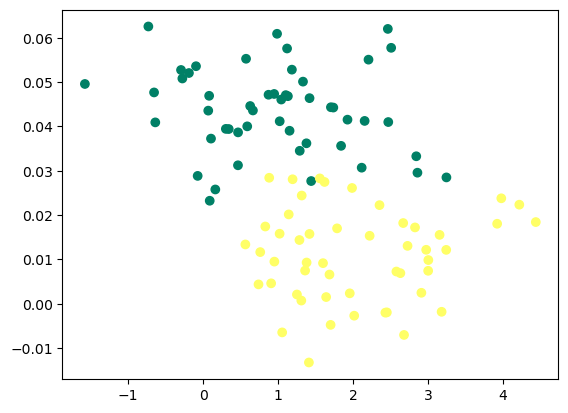

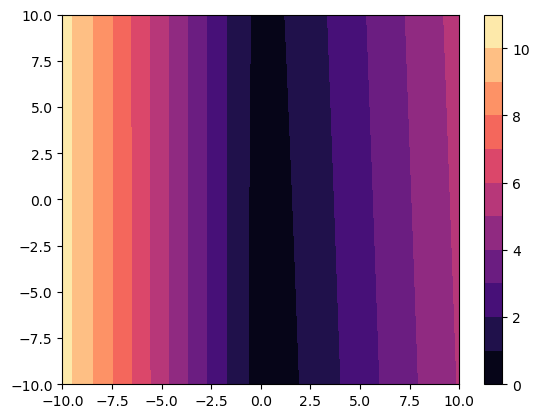

In [174]:
X, y = make_blobs(n_samples = 100, centers = 2, n_features = 2, random_state = 0)
y = y.reshape((y.shape[0]), 1)

X[:, 1] *= 0.01

plt.scatter(X[:,0], X[:, 1], c=y, cmap='summer')
plt.show()

b = 0
epsilon = 1e-15

Z = X.dot(W_final) + b
A = 1 / (1 + np.exp(-Z))

L = - 1 / len(y) * np.sum(y * np.log(A + epsilon) + (1 - y) * np.log(1 - A + epsilon), axis = 0).reshape(W11.shape)

plt.contourf(W11, W22, L, 10, cmap='magma')
plt.colorbar()

En somme, la normalisation permet à la descente de gradients d'optimiser ses déplacements et ainsi rendre les calculs plus pertinents.